# Heart Failure Prediction

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.

Heart failure is a common event caused by CVDs and this [dataset](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data) contains 12 features that can be used to predict mortality by heart failure.

In this notebook we will analyze data and try to build the accurate model to predict death  based on patient health description.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

sns.set_theme(style="darkgrid")

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.00,0,582,0,20,1,265000.00,1.90,130,1,0,4,1
1,55.00,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1
2,65.00,0,146,0,20,0,162000.00,1.30,129,1,1,7,1
3,50.00,1,111,0,20,0,210000.00,1.90,137,1,0,7,1
4,65.00,1,160,1,20,0,327000.00,2.70,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,0,61,1,38,1,155000.00,1.10,143,1,1,270,0
295,55.00,0,1820,0,38,0,270000.00,1.20,139,0,0,271,0
296,45.00,0,2060,1,60,0,742000.00,0.80,138,0,0,278,0
297,45.00,0,2413,0,38,0,140000.00,1.40,140,1,1,280,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Data is clean and has no non-null values. There are 12 numeric features and 299 rows. 

## Data Analysis

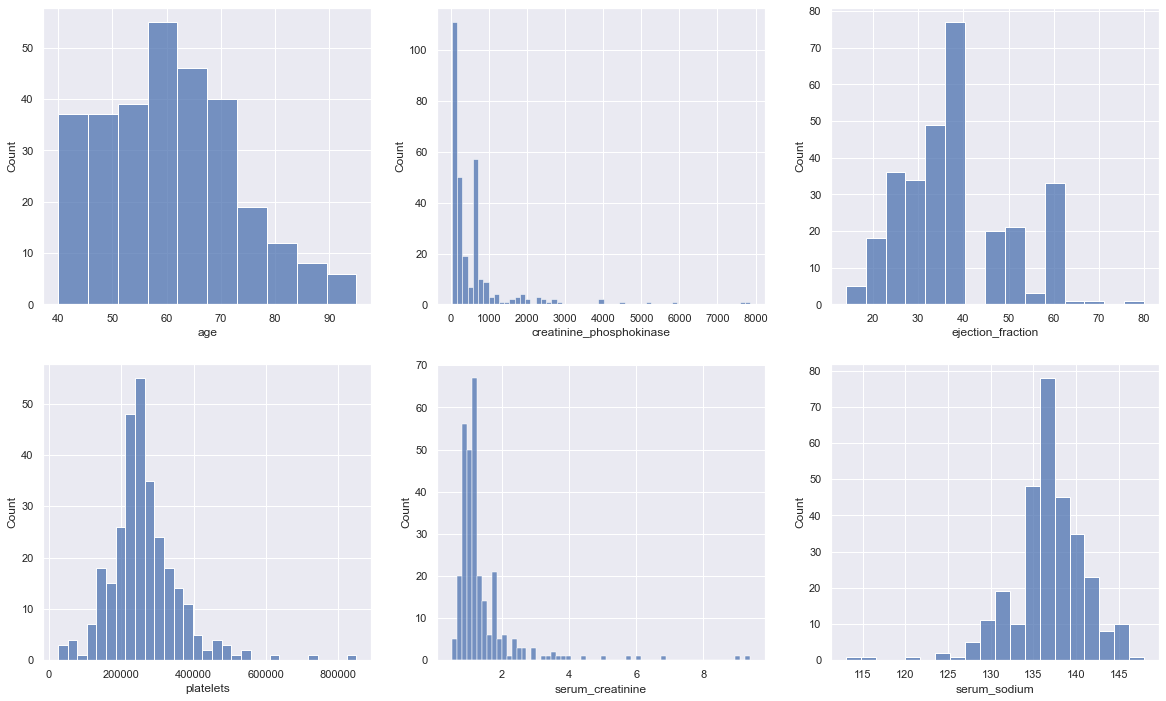

,count,mean,std,min,25%,50%,75%,max
age,299.00,60.83,11.89,40.00,51.00,60.00,70.00,95.00
creatinine_phosphokinase,299.00,581.84,970.29,23.00,116.50,250.00,582.00,7861.00
ejection_fraction,299.00,38.08,11.83,14.00,30.00,38.00,45.00,80.00
platelets,299.00,263358.03,97804.24,25100.00,212500.00,262000.00,303500.00,850000.00
serum_creatinine,299.00,1.39,1.03,0.50,0.90,1.10,1.40,9.40
serum_sodium,299.00,136.63,4.41,113.00,134.00,137.00,140.00,148.00


In [4]:
fig = plt.figure(figsize=(20,12))
continuous_columns = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
numeric_info = pd.DataFrame()
for i, column in enumerate(continuous_columns):
    ax = fig.add_subplot(2,3, i+1)
    sns.histplot(data[column], ax=ax)
    numeric_info=pd.concat([numeric_info, (round(pd.DataFrame(data[column].describe()).T, 2))])
plt.show()
numeric_info

All the continious columns are normally distributed except creatinine_phosphokinase and ejection_fraction. These two columns have some outliers, too.

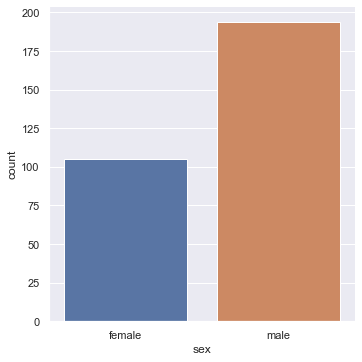

In [5]:
sns.catplot(x="sex", data=data, kind="count", label=["male", "female"])
plt.xticks([0, 1],["female", "male"])
plt.show()

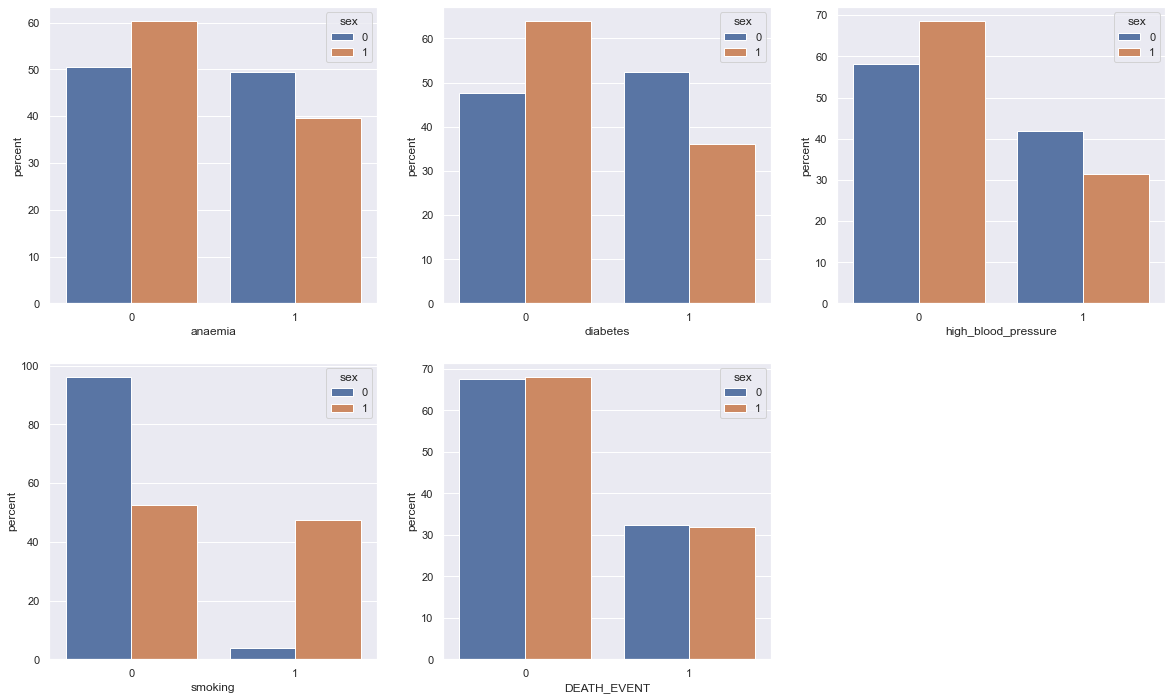

In [6]:
fig = plt.figure(figsize=(20,12))
categorical_columns = ["anaemia", "diabetes", "high_blood_pressure", "smoking", "DEATH_EVENT"]
sex_counts = np.array(data["sex"].value_counts().sort_index().append(data["sex"].value_counts().sort_index()))
for i, column in enumerate(categorical_columns):
    ax = fig.add_subplot(2,3, i+1)
    
    series = pd.Series(sex_counts, index = data.groupby(column)["sex"].value_counts().sort_index().index)
    (data
    .groupby(column)["sex"]
    .value_counts()
    .div(series)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.barplot,'data'), x=column,y='percent',hue="sex", ax=ax, tick_label=["female", "male"]))
#     ax.legend([0, 1],)


Data has more male patiences information that female. Many smokers are among men. Women are more likely to have diabetes, high blood pressure and anaemia than men. Heart related deaths are equally distributed among males and females. 

## Data Prepocessing

Time column tells us how many days past from patience's first day to their latest appointment or death. This information is useless and will not help our model

In [7]:
data = data.drop(["time"], axis=1)

Our dataset has different scales for each column, which means some columns that have bigger numbers affect predictions more than others. This can lead to mispredictions. To avoid that we need standardize our dataset 

In [8]:
def standardize(df):
    df = (df - df.min())/(df.max() - df.min())
    return df

data = standardize(data)

We need to split our dataset into two, so we can check our model's performance on validation dataset

In [9]:
data_validation = data.sample(frac=0.2)
data = data.drop(data_validation.index)

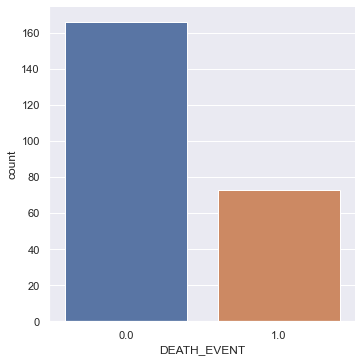

In [10]:
sns.catplot(x="DEATH_EVENT", data=data, kind="count")
plt.show()

Since we we have less death events our dataset is imbalanced. We will apply up-sampling to balance number of deaths

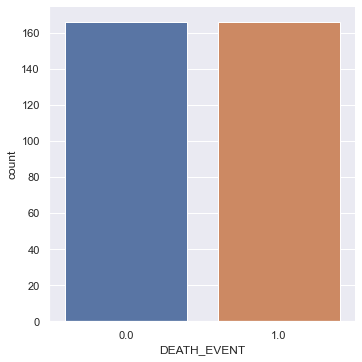

In [11]:
death_events = data[data["DEATH_EVENT"] == 1]
non_death_events = data[data["DEATH_EVENT"] == 0]

# randomly sampling dataset from death_events 
death_events_sample = resample(death_events, replace=True, n_samples=len(non_death_events), random_state=11) 
# concatenate death_events_sample and non_death_events, then shuffling 
balanced_data  = pd.concat([non_death_events, death_events_sample]).sample(frac=1, random_state=11) 

sns.catplot(x="DEATH_EVENT", data=balanced_data, kind="count")
plt.show()

Now we have equal number of patience who died from heart failure and who did not.

## Model

In [12]:
X, y = data.drop(["DEATH_EVENT"],1), data["DEATH_EVENT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=111)

clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.72it/s]


In [13]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.67,0.67,0.67,0.68,0.01
AdaBoostClassifier,0.71,0.62,0.62,0.69,0.10
LinearSVC,0.75,0.62,0.62,0.70,0.02
LogisticRegression,0.73,0.60,0.60,0.69,0.02
LinearDiscriminantAnalysis,0.73,0.60,0.60,0.69,0.01
SVC,0.73,0.60,0.60,0.69,0.02
DecisionTreeClassifier,0.69,0.59,0.59,0.67,0.03
QuadraticDiscriminantAnalysis,0.71,0.59,0.59,0.67,0.01
RidgeClassifierCV,0.73,0.58,0.58,0.67,0.02


Most of the Classifiers performed well on default parameters. I am going to choose __NearestCentroid__, __RandomForestClassifier__ and __XGBClassifier__, because they were in top ten when I experimented with random_state of the train_test_split.

## NearestCentroid

In [14]:
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import RandomizedSearchCV

models = {}

nearest_centroid_grid =  {'shrink_threshold': range(6),
                          "metric" : ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']}      

nc_random = RandomizedSearchCV(estimator = NearestCentroid(), param_distributions = nearest_centroid_grid, n_iter = 120, cv = 5, verbose=0, random_state=11)
nc_random.fit(X, y)

RandomizedSearchCV(cv=5, estimator=NearestCentroid(), n_iter=120,
                   param_distributions={'metric': ['cityblock', 'cosine',
                                                   'euclidean', 'l1', 'l2',
                                                   'manhattan'],
                                        'shrink_threshold': range(0, 6)},
                   random_state=11)

In [15]:
models["NearestCentroid"] = [nc_random.best_estimator_, nc_random.best_score_]
pprint(models)

{'NearestCentroid': [NearestCentroid(metric='cityblock', shrink_threshold=3),
                     0.6945921985815604]}


## RandomForestClassifier

In [16]:
from sklearn.ensemble import RandomForestClassifier


#find best performing parameters using randomized grid search 
random_forest_grid =  {'n_estimators': list(map(int, np.linspace(100, 2000, 11))),
                       'max_features': ['auto', 'sqrt', 'log2'],
                       'max_depth': list(range(5,100, 10)) + [None],
                       'min_samples_leaf': [1, 2, 4],
                       'min_samples_split': [2, 5, 10],
                       'bootstrap': [True, False]}      

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_forest_grid, n_iter = 120, cv = 5, verbose=0, random_state=11)
rf_random.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=120,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 25, 35, 45, 55, 65,
                                                      75, 85, 95, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 290, 480, 670,
                                                         860, 1050, 1240, 1430,
                                                         1620, 1810, 2000]},
                   random_state=11)

In [17]:
models["RandomForestClassifier"] = [rf_random.best_estimator_, rf_random.best_score_]
pprint(models)

{'NearestCentroid': [NearestCentroid(metric='cityblock', shrink_threshold=3),
                     0.6945921985815604],
 'RandomForestClassifier': [RandomForestClassifier(max_depth=95, max_features='log2', min_samples_leaf=2),
                            0.7323581560283688]}


## XGBClassifier

In [18]:
from xgboost import XGBClassifier

xgboost_grid = {'n_estimators': list(map(int, np.linspace(100, 2000, 11))),
                'max_depth': list(range(3,20, 2)) + [None],
                'min_child_weight':range(1,6,2),
                'max_delta_step': range(0, 8, 2)} 

xgb_random = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = xgboost_grid, n_iter = 120, cv = 5, verbose=0, random_state=11)
xgb_random.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [19]:
models["XGBClassifier"] = [xgb_random.best_estimator_, xgb_random.best_score_]
pprint(models)

{'NearestCentroid': [NearestCentroid(metric='cityblock', shrink_threshold=3),
                     0.6945921985815604],
 'RandomForestClassifier': [RandomForestClassifier(max_depth=95, max_features='log2', min_samples_leaf=2),
                            0.7323581560283688],
 'XGBClassifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=2, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1620, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
                   0.7156028368794326]}


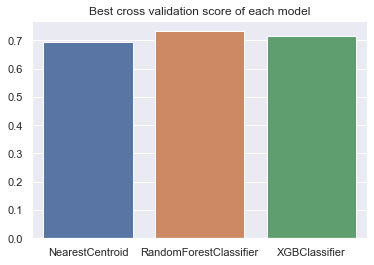

In [20]:
sns.barplot(x = list(models.keys()), y = [j[1] for i, j in models.items()])
plt.title("Best cross validation score of each model")
plt.show()

So far RandomForestClassifier is leading. Let's see how our models perform on validation dataset

## Testing models' accuracy on validation dataset

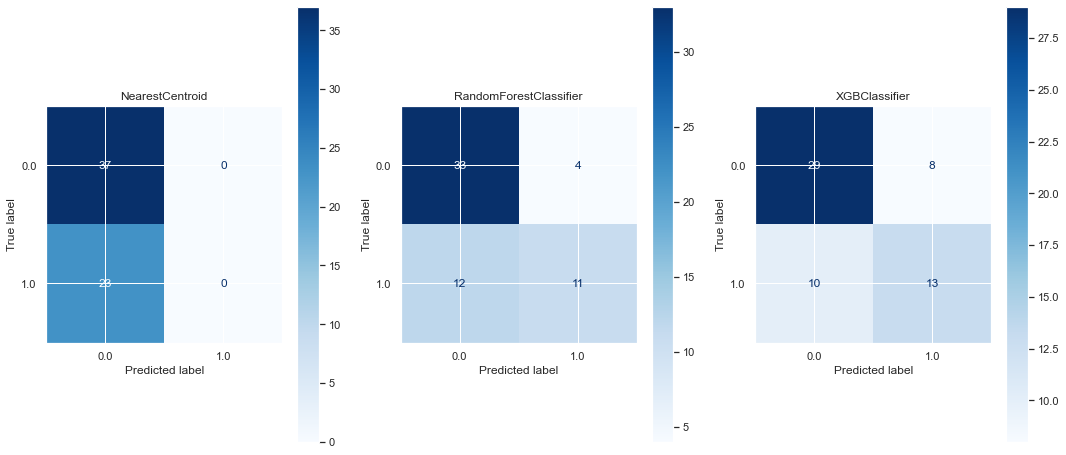

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

fig = plt.figure(figsize=(18, 8))
for i, (model_name, model_info) in enumerate(models.items()):
    features, target = data_validation.drop("DEATH_EVENT", axis=1), data_validation["DEATH_EVENT"]
    prediction = model_info[0].predict(features)
    accuracy = accuracy_score(target, prediction)
    models[model_name].append(accuracy)
    
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title(model_name)
    plot_confusion_matrix(model_info[0], features, target, cmap='Blues', ax=ax)

NearestCentroid predicted everything 0, which is not what we want. In the meantime, RandomForestClassifier and XGBClassifier have almost identical results

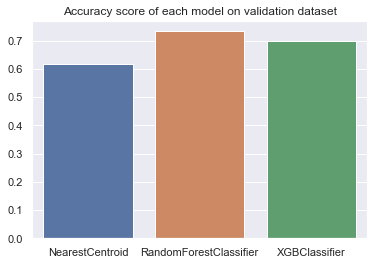

In [22]:
sns.barplot(x = list(models.keys()), y = [j[2] for i, j in models.items()])
plt.title("Accuracy score of each model on validation dataset")
plt.show()

In [23]:
dict(zip(models.keys(),[j[2] for i, j in models.items()]))

{'NearestCentroid': 0.6166666666666667,
 'RandomForestClassifier': 0.7333333333333333,
 'XGBClassifier': 0.7}

RandomForestClassifier is still beating other classifiers with the score of 0.73

## Conclusion

Eventhough RandomForestClassifier has performed better than other models, I would not use this model for production. RandomForestClassifier still needs improvement like more various data, feature engineering. Alternative solution is to experiment hyperparameter tuning with other machine learning algorithms. 